In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize

# --------------------------
# Global assumptions
# --------------------------
ASSUMPTIONS = {
    "T0": 308.0,          # K ambient (~35°C)
    "Te": 278.0,          # K evaporator (~5°C)
    "Tc": 313.0,          # K condenser (~40°C)
    "G": 900.0,           # W/m² irradiance
    "eta_pv": 0.20,       # PV efficiency (electric)
    "L_cool_req": 2000.0, # W cooling requirement (2 kW)
    "beta": 0.25,         # PV must cover fraction of Qh

    # Simple cost model (illustrative — adjust to your case)
    "c_A": 600.0,         # $/m² adsorber/HX
    "c_pv": 120.0,        # $/m² PV
    "C_fixed": 800.0,     # $ fixed BOS
    "c_ex": 5,         # $ per watt of (Wpv - cooling exergy)
}

# Design variable bounds: [A, A_pv, T_h, tau]
BOUNDS = {
    "A":   (0.8, 6.0),      # m² adsorber effective area
    "A_pv":(4.0, 30.0),     # m² PV area
    "T_h": (355.0, 395.0),  # K regeneration temp (~82–122°C)
    "tau": (300.0, 1400.0)  # s cycle time (~5–23 min)
}

In [16]:
def cop_surrogate(A, Th, tau, P=ASSUMPTIONS):
    # COP increases with A (diminishing), tau (diminishing), and with Th above Te,Tc
    a0, tau0 = 0.5, 600.0
    alpha_eff, beta_tau, K = 0.6, 0.4, 9.0
    Te, Tc = P["Te"], P["Tc"]

    drv = max(1.0 - Te/Th, 0.0) * max(1.0 - Tc/Th, 0.0)   # zero if Th too low (COP can't be negative)
    area_util = A / (A + a0)
    cycle_eff = alpha_eff + beta_tau * (tau/(tau + tau0))
    COP = area_util * drv * cycle_eff * K
    return max(0.05, min(COP, 0.9))

def capacity_surrogate(A, Th, tau, P=ASSUMPTIONS):
    # Cooling power ~ UA*ΔT * cycle factor * temperature driving factor
    k_UA, dT = 600.0, 5.0
    tau0, Te, Tc = 600.0, P["Te"], P["Tc"]
    cycle_eff = 0.5 + 0.5*(tau/(tau + tau0))
    psiT = max(0.15, (1.0 - Te/Th)*(1.0 - Tc/Th))
    Qe = (k_UA * A) * dT * cycle_eff * psiT  # W
    return max(0.0, Qe)

def pv_power(A_pv, P=ASSUMPTIONS):
    return P["eta_pv"] * P["G"] * A_pv   # W electric

def cooling_exergy(Qe, P=ASSUMPTIONS):
    return abs(1.0 - P["T0"]/P["Te"]) * Qe  # W

def evaluate_design(A, A_pv, Th, tau, P=ASSUMPTIONS):
    """
    Returns a dictionary with:
      Qe, COP_th, Qh, Wpv, Ecool, E_dest, C_construct, C_exergy, C_total
      + feasibility flags (constraints)
    Swap this function with your detailed balances when ready.
    """
    # Performance
    COP   = cop_surrogate(A, Th, tau, P)
    Qe    = capacity_surrogate(A, Th, tau, P)     # W (useful)
    Qh    = Qe / max(COP, 1e-6)                   # W (heat input needed)
    Wpv   = pv_power(A_pv, P)                     # W (electric)
    Ecool = cooling_exergy(Qe, P)                 # W

    # Exergy accounting (simple, consistent form)
    # Exergy of heat at Th: Eh = Qh * (1 - T0/Th)
    Eh    = Qh * max(0.0, 1.0 - P["T0"]/Th)
    # Here we consider exergy input as Eh (heater’s thermal exergy).
    # Exergy destruction (system-level):
    E_dest = Eh - Ecool
    E_dest = max(E_dest, 0.0)  # avoid tiny negative due to surrogates

    # Costs
    C_construct = P["c_A"]*A + P["c_pv"]*A_pv + P["C_fixed"]
    # Penalize if PV electric greatly exceeds cooling exergy (quality mismatch)
    C_exergy    = P["c_ex"] * max(0.0, Wpv - Ecool)
    C_total     = C_construct + C_exergy

    # Constraints
    feasible_load = Qe >= P["L_cool_req"]     # ≥ 2 kW
    feasible_pv   = Wpv >= P["beta"] * Qh     # PV can support fraction of Qh
    feasible_cop  = (COP > 0.2) and (Th > P["Tc"])
    feasible      = feasible_load and feasible_pv and feasible_cop

    return {
        "A": A, "A_pv": A_pv, "T_h": Th, "tau": tau,
        "Qe": Qe, "COP_th": COP, "Qh": Qh, "Wpv": Wpv,
        "Ecool": Ecool, "E_dest": E_dest,
        "C_construct": C_construct, "C_exergy": C_exergy, "C_total": C_total,
        "feasible_load": feasible_load,
        "feasible_pv": feasible_pv,
        "feasible_cop": feasible_cop,
        "feasible": feasible
    }

In [17]:
class AdsorptionMOProblem(ElementwiseProblem):
    """
    NSGA-II problem:
      Minimize F = [ C_total , E_dest ]
      Subject to:
        g1 = L_cool_req - Qe      <= 0   (Qe >= required)
        g2 = beta*Qh - Wpv        <= 0   (PV covers fraction of Qh)
        g3 = 0.2 - COP_th         <= 0   (COP > 0.2)
        g4 = Tc - T_h             <= 0   (T_h > Tc)
    """
    def __init__(self, bounds=BOUNDS, P=ASSUMPTIONS):
        xl = [bounds["A"][0], bounds["A_pv"][0], bounds["T_h"][0], bounds["tau"][0]]
        xu = [bounds["A"][1], bounds["A_pv"][1], bounds["T_h"][1], bounds["tau"][1]]
        super().__init__(n_var=4, n_obj=2, n_constr=4, xl=xl, xu=xu)
        self.P = P

    def _evaluate(self, x, out, *args, **kwargs):
        A, A_pv, Th, tau = x
        r = evaluate_design(A, A_pv, Th, tau, self.P)
        # Objectives
        out["F"] = [r["C_total"], r["E_dest"]]
        # Constraints (<= 0 is feasible)
        g1 = self.P["L_cool_req"] - r["Qe"]
        g2 = self.P["beta"]*r["Qh"] - r["Wpv"]
        g3 = 0.2 - r["COP_th"]
        g4 = self.P["Tc"] - r["T_h"]
        out["G"] = [g1, g2, g3, g4]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      120 |      3 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      240 |      6 |  0.000000E+00 |  0.000000E+00 |  0.1554532657 |         ideal
     3 |      360 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0218086289 |         ideal
     4 |      480 |      5 |  0.000000E+00 |  0.000000E+00 |  0.1785435886 |         ideal
     5 |      600 |      5 |  0.000000E+00 |  0.000000E+00 |  0.1122614417 |         ideal
     6 |      720 |      1 |  0.000000E+00 |  0.000000E+00 |  1.644570E+02 |         ideal
     7 |      840 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     8 |      960 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0128557262 |         ideal
     9 |     1080 |      3 |  0.000000E+00 |  0.000000E+00 |  1.0460255212 |         ideal
    10 |     1200 |      4 |  0.000000E+00 |  0.000000E+00 |  0.4702824651 |         ideal

,A,A_pv,T_h,tau,C_total,E_dest,Qe,COP_th,Qh,Wpv,Ecool,CV,feasible
0,5.228842,6.249331,395.0,1399.817465,9232.486348,775.205805,2000.000013,0.444492,4499.518298,1124.879575,215.827340,0.0,True
1,5.228842,6.249331,395.0,1399.817464,9232.486348,775.205805,2000.000013,0.444492,4499.518298,1124.879575,215.827340,0.0,True
2,5.228842,6.249331,395.0,1399.817463,9232.486348,775.205805,2000.000013,0.444492,4499.518298,1124.879575,215.827340,0.0,True
3,5.228842,6.249331,395.0,1399.817462,9232.486348,775.205805,2000.000013,0.444492,4499.518298,1124.879575,215.827340,0.0,True
4,5.228842,6.249331,395.0,1399.817462,9232.486348,775.205805,2000.000013,0.444492,4499.518298,1124.879575,215.827340,0.0,True
5,5.228842,6.249331,395.0,1399.817461,9232.486348,775.205805,2000.000013,0.444492,4499.518298,1124.879575,215.827339,0.0,True
6,5.228842,6.249331,395.0,1399.817460,9232.486348,775.205805,2000.000012,0.444492,4499.518298,1124.879575,215.827339,0.0,True
7,5.228842,6.249331,395.0,1399.817460,9232.486349,775.205805,2000.000012,0.444492,4499.518298,1124.879575,215.827339,0.0,True
8,5.228842,6.249331,395.0,1399.817459,9232.486349,775.205805,2000.000012,0.444492,4499.518298,1124.879575,215.827339,0.0,True
9,5.228842,6.249331,395.0,1399.817458,9232.486349,775.205805,2000.000012,0.444492,4499.518297,1124.879575,215.827339,0.0,True


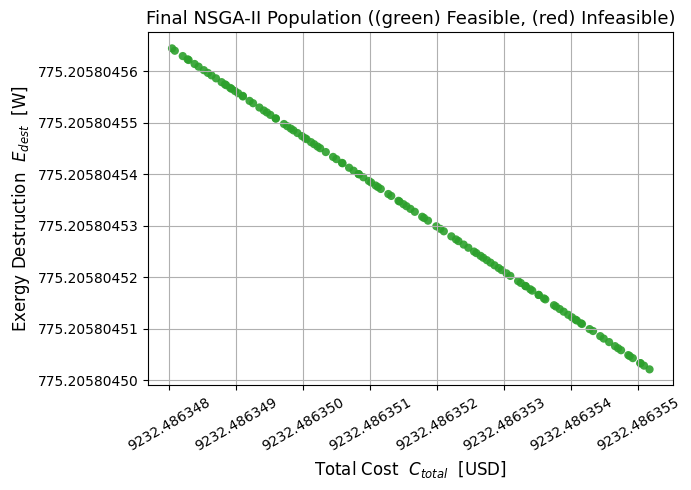

In [18]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.sampling import Sampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- helper: feasibility check ----------
def is_feasible_vec(x):
    A, A_pv, Th, tau = x
    r = evaluate_design(A, A_pv, Th, tau, ASSUMPTIONS)
    g1 = ASSUMPTIONS["L_cool_req"] - r["Qe"]         # ≤0 OK
    g2 = ASSUMPTIONS["beta"]*r["Qh"] - r["Wpv"]      # ≤0 OK
    g3 = 0.2 - r["COP_th"]                           # ≤0 OK
    g4 = ASSUMPTIONS["Tc"] - r["T_h"]                # ≤0 OK
    feasible = (g1 <= 0) and (g2 <= 0) and (g3 <= 0) and (g4 <= 0)
    CV = max(0.0, g1) + max(0.0, g2) + max(0.0, g3) + max(0.0, g4)  # total violation
    return feasible, CV


# ---------- custom feasible sampling for NSGA-II ----------
class FeasibleSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        xl, xu = np.array(problem.xl), np.array(problem.xu)
        X = []
        trials = 0
        while len(X) < n_samples and trials < 20000:
            rnd = np.random.rand(4)
            cand = xl + rnd * (xu - xl)
            ok, _ = is_feasible_vec(cand)
            if ok:
                X.append(cand)
            trials += 1
        # if still not full, fill with randoms (NSGA-II will repair later)
        while len(X) < n_samples:
            rnd = np.random.rand(4)
            X.append(xl + rnd * (xu - xl))
        return np.array(X)


# ---------- NSGA-II multi-objective problem ----------
class AdsorptionMOProblem(ElementwiseProblem):
    def __init__(self, bounds=BOUNDS, P=ASSUMPTIONS):
        xl = [bounds["A"][0], bounds["A_pv"][0], bounds["T_h"][0], bounds["tau"][0]]
        xu = [bounds["A"][1], bounds["A_pv"][1], bounds["T_h"][1], bounds["tau"][1]]
        super().__init__(n_var=4, n_obj=2, n_constr=4, xl=xl, xu=xu)
        self.P = P

    def _evaluate(self, x, out, *args, **kwargs):
        A, A_pv, Th, tau = x
        r = evaluate_design(A, A_pv, Th, tau, self.P)
        out["F"] = [r["C_total"], r["E_dest"]]     # objectives
        # constraints (≤ 0 feasible)
        g1 = self.P["L_cool_req"] - r["Qe"]
        g2 = self.P["beta"]*r["Qh"] - r["Wpv"]
        g3 = 0.2 - r["COP_th"]
        g4 = self.P["Tc"] - r["T_h"]
        out["G"] = [g1, g2, g3, g4]


# ---------- run NSGA-II ----------
algorithm = NSGA2(pop_size=120, sampling=FeasibleSampling())
termination = get_termination("n_gen", 500)
problem = AdsorptionMOProblem()

res = minimize(problem, algorithm, termination, verbose=True)


# ---------- extract ALL individuals (feasible + infeasible) ----------
pop = res.algorithm.pop
F = pop.get("F")        # objective values
X = pop.get("X")        # decision variables
G = pop.get("G")        # constraint violations

CV = np.clip(G, 0, None).sum(axis=1)      # aggregate violation
feas_mask = CV <= 1e-9                    # feasible mask


# ---------- build DataFrame ----------
rows = []
for i in range(len(X)):
    A, A_pv, Th, tau = X[i]
    r = evaluate_design(A, A_pv, Th, tau, ASSUMPTIONS)
    rows.append({
        "A": A,
        "A_pv": A_pv,
        "T_h": Th,
        "tau": tau,
        "C_total": F[i, 0],
        "E_dest": F[i, 1],
        "Qe": r["Qe"],
        "COP_th": r["COP_th"],
        "Qh": r["Qh"],
        "Wpv": r["Wpv"],
        "Ecool": r["Ecool"],
        "CV": float(CV[i]),
        "feasible": bool(feas_mask[i])
    })

pop_df = pd.DataFrame(rows).sort_values(
    ["feasible", "C_total", "E_dest"], ascending=[False, True, True]
).reset_index(drop=True)

# ---------- summary ----------
total = len(pop_df)
n_feas = feas_mask.sum()
n_infeas = total - n_feas
print(f"✅ Total designs: {total} | 🟩 Feasible: {n_feas} | 🟥 Infeasible: {n_infeas}")

display(pop_df.head(20))

# ---------- plot: show ALL (green = feasible, red = infeasible) ----------
colors = np.where(pop_df["feasible"], "tab:green", "tab:red")

plt.figure(figsize=(7,5))
plt.scatter(
    pop_df["C_total"], pop_df["E_dest"],
    c=colors, s=35, alpha=0.9, edgecolors="none"
)

# Force Matplotlib to show true numbers instead of scientific offset
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.ticklabel_format(style='plain', axis='y', useOffset=False)

# Optional: set tighter tick formatting for readability
plt.xticks(rotation=30)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.xlabel("Total Cost  $C_{total}$  [USD]", fontsize=12)
plt.ylabel("Exergy Destruction  $E_{dest}$  [W]", fontsize=12)
plt.title("Final NSGA-II Population ((green) Feasible, (red) Infeasible)", fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.show()